Leveraging LLM Reasoning Enhances Personalized Recommender Systems(2024)에서 제안된 LLM을 이용한 추천시스템 제작 방안임

[필요한 파일]

크롤링 후 후처리 및 태깅 완료 데이터 : crawl_complete_data.csv

사용자의 가상 HISTORY 데이터 : user_history.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 사용자별 데이터 가져오기

각각의 가상의 사용자가 찾은 공지들의 태그에 관한 기록임.

이 태그는 공지들의 태그목록을 바탕으로 총 출현 횟수 중 5회 이상 출현한 태그들만 담겨있음. 5회 미만 출현한 태그는 특수성이 강한 태그라고 판단했음.

우리는 일반적인 패턴에 대해서 사용자에게 추천해줘야 하기때문에 위와 같은 방법을 사용함.

In [2]:
# 각 사용자별 HISTORY데이터 정리하기 - [1 데이터 불러오기]
import pandas as pd
import ast

user_history_df = pd.read_csv('/content/drive/MyDrive/sanhak/user_history.csv')
user_history_df.columns = ['history']

print(f'user history df shape : {user_history_df.shape}')
print(user_history_df.head())

user history df shape : (153, 1)
                                             history
0  ['일반인', '중학생', '대학생', '대출지원', '기타지원', '초등학생', ...
1  ['보안', 'UI/UX', '무료교육', '사이버보안', '학점인정', '서버',...
2  ['application', '신청 안내', 'event', '장학금', '학생 모...
3  ['시상', '공모전', '공모전', '공모전', '참여', 'UCC', '공모전'...
4  ['취업 지원', '무료 교육', '강연', '교육과정', '취업 지원', '무료 ...


In [3]:
# 각 사용자별 HISTORY데이터 정리하기 - [2 사용자별 태그 출현횟수 내림차순 정렬]

user_history_tag_freq = []

for key, value in user_history_df.iterrows():
    curr_freq_dict = {}
    curr_list = ast.literal_eval(value['history'])

    for tag in curr_list:
        if tag in curr_freq_dict:
            curr_freq_dict[tag] += 1
        else:
            curr_freq_dict[tag] = 1

    curr_freq_dict = dict(sorted(curr_freq_dict.items(), key=lambda x: x[1], reverse=True))
    user_history_tag_freq.append( curr_freq_dict )

print(f'user history 수 : {len(user_history_tag_freq)}')

user history 수 : 153


In [4]:
user_history_tag_freq

[{'장학금': 9,
  '대학생': 7,
  '중학생': 5,
  '청년': 5,
  '기타지원': 4,
  '초등학생': 4,
  '지역기준': 4,
  '대출지원': 3,
  '전문대': 3,
  '고등학생': 3,
  '일반인': 2,
  '대학원생': 1},
 {'AI': 5,
  '온라인 교육': 4,
  '보안': 2,
  '학점인정': 2,
  '부트캠프': 2,
  'AI 교육': 2,
  '국비지원': 2,
  '빅데이터': 2,
  '교육': 2,
  '3D': 2,
  '클라우드': 2,
  '프론트엔드': 2,
  '인공지능': 2,
  '국비지원 교육': 2,
  '백엔드': 2,
  'UI/UX': 1,
  '무료교육': 1,
  '사이버보안': 1,
  '서버': 1,
  '훈련비 지원': 1,
  '교육과정': 1,
  '인턴': 1,
  '백엔드 개발': 1,
  '데이터 분석': 1,
  '취업': 1,
  '무료 교육': 1,
  '고용노동부': 1,
  '신청 방법': 1,
  '국비 지원': 1,
  '게임': 1},
 {'신청 안내': 5,
  '공모전': 4,
  '학생 모집': 3,
  '창업': 3,
  '콘텐츠 제작': 3,
  '장학금': 2,
  '학생 지원': 2,
  '모임': 2,
  '취업': 2,
  'UCC': 2,
  '인턴': 2,
  '대학생 참여': 2,
  '서포터즈 모집': 2,
  '기획': 2,
  'application': 1,
  'event': 1,
  '신청 방법': 1,
  '진로탐색': 1,
  '차세대통신': 1,
  '문의': 1,
  '포스터': 1,
  '공모': 1,
  '학생 참여': 1,
  '멘토링 프로그램': 1,
  '대학일자리센터': 1,
  '지원 자격': 1,
  '재학생 참여': 1,
  '영상': 1},
 {'공모전': 17,
  'UCC': 6,
  '서포터즈': 5,
  '시상': 4,
  '참여': 4,
  '이벤트': 3,
  'event'

## 2. 공지 태그 데이터 가져오기

각각 공지들에 대한 태그 데이터임. 위에서 했던대로 threshold를 설정해서 5회 미만 출현한 태그들은 특수성이 강한 태그로 분류하므로 공지 태그에서도 마찬가지로 삭제해줌

In [5]:
# 각 공지별 TAG데이터 정리하기 - [1 COMMON TAG 및 RARE TAG set만들기]
notice_df = pd.read_csv('/content/drive/MyDrive/sanhak/crawl_complete_data.csv')


## threshold setting ##
threshold = 5



tags_freq = {}

for key, value in notice_df.iterrows():
    curr_list = ast.literal_eval(value['tag'])

    for tag in curr_list:
        if tag in tags_freq:
            tags_freq[tag] += 1
        else:
            tags_freq[tag] = 1

tags_freq = dict(sorted(tags_freq.items(), key=lambda item: item[1], reverse=True))

count = sum(1 for value in tags_freq.values() if value >= threshold)

print(f"value가 {threshold} 이상인 항목의 수:", count)

common_tags_set = {key for key, value in tags_freq.items() if value >= threshold}
rare_tags_set = {key for key, value in tags_freq.items() if value < threshold}

print(f'common_tags_set length : {len(common_tags_set)}')
print(f'rare_tags_set length : {len(rare_tags_set)}')

value가 5 이상인 항목의 수: 165
common_tags_set length : 165
rare_tags_set length : 2463


In [6]:
# 각 공지별 TAG데이터 정리하기 = [2 COMMON TAG만 남기기]
notice_tag = []

for key, value in notice_df.iterrows():
    curr_list = ast.literal_eval(value['tag'])
    avail_list = []

    for tag in curr_list:
        if tag in common_tags_set:
            avail_list.append(tag)

    notice_tag.append( avail_list )

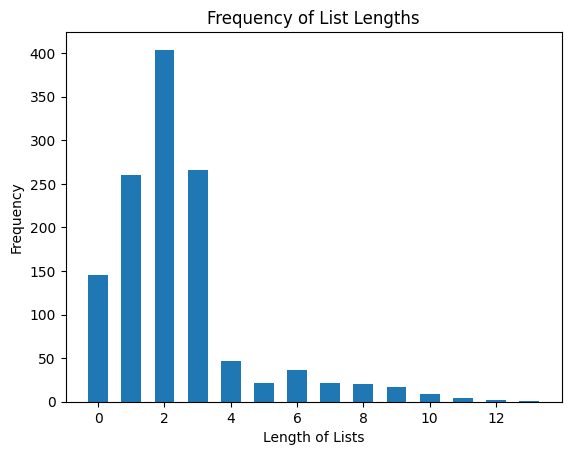

총 공지 수 : 1255


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

lengths = [len(lst) for lst in notice_tag]

# 각 길이의 빈도수 계산
length_counts = Counter(lengths)

# 막대 그래프 생성
plt.bar(length_counts.keys(), length_counts.values(), width=0.6)
plt.xlabel("Length of Lists")
plt.ylabel("Frequency")
plt.title("Frequency of List Lengths")
plt.show()

print(f'총 공지 수 : {len(notice_tag)}')

## 3. User History와 공지 Tag들을 연관지어 목표 평점 R 레이팅 해주기

In [12]:
# 여기에 사용자 history와 공지 tag에 기반한 목표 평점을 저장하여 후에 DataFrame으로 바꿔 csv파일로 만듦
RecSAVER_dict = {
    'user_history_freq' : [],
    'notice_tag' : [],
    'target_rating' : []
}

In [13]:
# 목표 평점을 입력하는 과정
for user_history in user_history_tag_freq:
    for notice in notice_tag:
        target_rating = 0
        for tag in notice:
            if tag in user_history:
                if(user_history[tag] < 5): # 덜 나오는 것들은 가중치 줄임
                    target_rating += (user_history[tag] * 0.015)
                else: # 자주 나오는 것들은 가중치 높임
                    target_rating += (user_history[tag] * 0.025)
        if target_rating < 0.4: # threshold 설정
            target_rating = 0 # -> 관심 없어함으로 예상됨
        else:
            target_rating = 1 # -> 관심 있어함으로 예상됨

        RecSAVER_dict['user_history_freq'].append(user_history)
        RecSAVER_dict['notice_tag'].append(notice)
        RecSAVER_dict['target_rating'].append(target_rating)

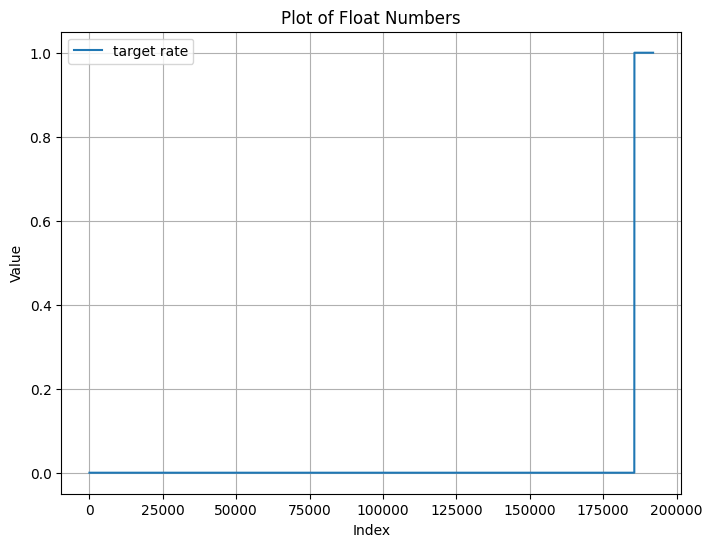

In [14]:
a = sorted(RecSAVER_dict['target_rating'])

plt.figure(figsize=(8, 6))
plt.plot(a, linestyle='-', label='target rate')
plt.title('Plot of Float Numbers')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df = pd.DataFrame(RecSAVER_dict)

# 목표평점이 1인것들을 10000개만 랜덤으로 남기고 나머지는 버리기
target_1_df = df[df['target_rating'] == 0]
target_2_df = df[df['target_rating'] == 1]
print(f'target_1_df shape : {target_1_df.shape}')
print(f'target_2_df shape : {target_2_df.shape}')


sampled_1_df = target_1_df.sample(n=2000, random_state=42)
sampled_2_df = target_2_df.sample(n=2000, random_state=42)

final_df = pd.concat([sampled_1_df, sampled_2_df])
final_df = final_df.sample(frac=1, random_state=42)

print(f'final_df shape : {final_df.shape}')

target_1_df shape : (185613, 3)
target_2_df shape : (6402, 3)
final_df shape : (4000, 3)


In [17]:
value_counts = final_df['target_rating'].value_counts()

# 결과 출력
print(value_counts.sort_index())

target_rating
0    2000
1    2000
Name: count, dtype: int64


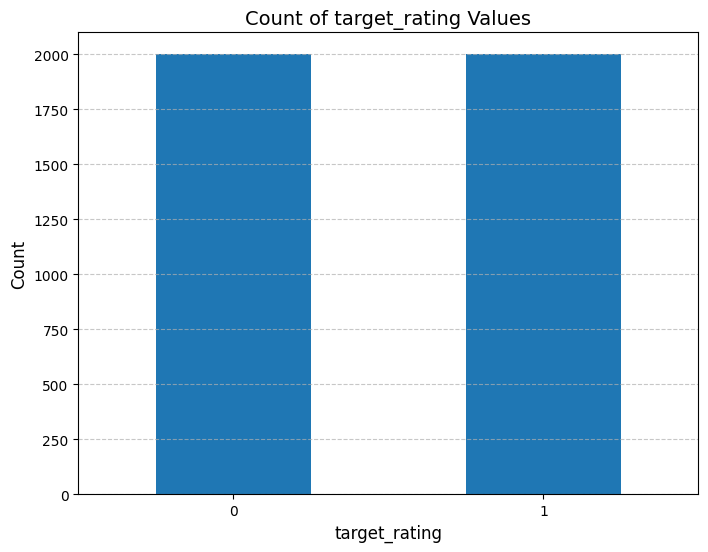

In [18]:
# 막대그래프 생성
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')

# 그래프 꾸미기
plt.title("Count of target_rating Values", fontsize=14)
plt.xlabel("target_rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.show()

## 4. User History, Notice Tag, Target Rating을 주고 설명문 생성하기(영문으로 생성)

In [19]:
final_df

,user_history_freq,notice_tag,target_rating
67342,"{'취업': 8, '교육': 6, '전시': 4, '교육 프로그램': 4, '인턴'...","[포트폴리오 제작, 빅데이터, AI, 교육생 모집, AI 교육]",0
144609,"{'교육': 23, '강연': 18, '무료교육': 9}","[교육, 게임]",1
85496,"{'취업': 17, '교육': 14, '취업지원': 8, '부트캠프': 6, '교육...","[기획, 공모전]",0
186726,"{'모임': 28, '서포터즈': 22}","[동아리, 모임, 봉사, 모집]",1
190528,"{'대학원생': 21, '장학금': 17, '대학생': 12}","[장학금, 대학원생]",1
...,...,...,...
72952,"{'교육': 10, '취업': 7, '청년': 6, '인턴': 6, '강연': 5,...","[공모전, 참가자격]",0
60827,"{'마케팅': 8, '보안': 8, '교육': 8, '취업': 7, 'AI': 4,...","[접수방법, 공모전]",0
154349,"{'모집 안내': 14, '재학생': 13, '학생지원': 12, '국제교류': 11}",[],0
186638,"{'모임': 28, '서포터즈': 22}","[서포터즈, 기자단]",1


In [20]:
!pip install openai

In [22]:
# Open AI settings
from openai import OpenAI

client = OpenAI(api_key='your-openai-api-key')

def get_response(client, prompt, model='gpt-4o-mini'):

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "너는 나에게 회귀 모델의 학습을 위한 데이터를 만들어주는 도우미야. 해당 모델은 프롬프트 내용을 바탕으로 긍정적인지 부정적인지를 1과 0으로 나타내는 T5계열의 회귀 모델이야"},
                {"role": 'user', "content": prompt}
            ]
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error: {e}")
        return None

In [26]:
final_df.to_csv('data.csv')
print(final_df.shape)

(4000, 3)


In [27]:
# 우선 10개만 갖고 설명생성 테스트 하기
from tqdm import tqdm
import ast

sampled_df = final_df.iloc[0:]

generated_dataset = {
    'prompt':[],
    'target_rating':[]
}


for key, value in tqdm(sampled_df.iterrows()):
    history_freq = value['user_history_freq'] # dict
    notice_tag = value['notice_tag'] # list
    target_rating = value['target_rating']

    # target_rating
    target_rating_str = str(target_rating)

    # history_freq를 설명하는 영문 프롬프트
    history_freq_prompt_str = '아래는 어떤 사용자가 찾아본 공지들의 키워드를 나타내는 태그 기록과 해당 태그를 몇 번 검색했는지를 나타내는 딕셔너리야. \n\n '
    for key, val in history_freq.items():
        history_freq_prompt_str += f'{val}times of {key}, '
    history_freq_prompt_str = history_freq_prompt_str[:-2] + '.\n\n\n'

    # notice_tag를 설명하는 영문 프롬프트
    notice_tag_prompt_str = '그리고 새로운 공지의 키워드를 나타내는 태그 정보를 줄게. '
    if notice_tag:
        notice_tag_prompt_str += '이 공지의 키워드는 ' + ', '.join(notice_tag) + '이야.'
    else:
        notice_tag_prompt_str += "다만 이 공지에선 중요한 키워드가 없는것 같아."

    # final_prompt = ['나는 너한테 어떤 사용자의 최근 50개의 "공지 검색기록"과 "새로운 공지의 키워드정보"를 주고, 이 사용자가 해당 공지에 관심이 있는지 없는지에 대한 "목표평점"에 대한 정보 총 3개를 줄거야.',
    #                 '너는 "목표평점"을 정답을 삼아서 두가지 정보(공지 검색기록, 새로운 공지의 키워드정보)로 사용자가 관심있어하는지 관심없어하는지는 논리적으로 설명해주면 될 것 같아.',
    #                 '예를 들어보면 다음과 같아.\n',
    #                 '[예시 1]',
    #                 '공지검색기록을 바탕으로 사용자는 A태그는 20번, B태그는 10번, C태그는 20번 검색해보았습니다. 새로운 공지의 키워드는 B, C입니다. 사용자의 공지 검색 기록을 바탕으로 최근 50개 공지 기록 중 절반 이상인 B태그 10개, C태그 20개 총 30개에 대하여 연관되어 있으므로 사용자는 새로운 공지에 관심이 있을 것 입니다.\n',
    #                 '[예시 2]',
    #                 '공지검색기록을 바탕으로 사용자는 A태그는 20번, B태그는 10번, C태그는 10번, D태그는 10번 검색해보았습니다. 새로운 공지의 키워드는 C, E입니다. 사용자의 공지 검색 기록을 바탕으로 최근 50개의 공지 기록 중 적은 비율인 10개에 대하여 연관되어 있으므로 사용자는 새로운 공지에 관심이 없을 것 입니다.\n',
    #                 '[예시 3]',
    #                 '공지검색기록을 바탕으로 사용자는 각 A~E태그를 10번씩 검색해보았습니다. 그러나 새로운 공지의 키워드는 없습니다. 이는 새로운 공지가 너무 특수한 공지이므로 사용자의 공지 검색 기록을 바탕으로 사용자가 선호하는지 예측이 불가능합니다. 따라서 안전하게 사용자는 이 공지에 대하여 관심이 없을 것 입니다.\n',
    #                 '지금부터 "목표평점", "공지 검색기록", "새로운 공지의 키워드 정보"를 줄게. 문장을 생성해줘.',
    #                 '모든 문장은 영어로 생성해줘야 하고 너에게 주는 메타데이터들은 영어로 변환될때 같은 모양을 하고 있는 한국어 단어는 같은 단어로 번역되어야 해. 이 부분을 잘 지켜주면 너에게 500달러의 팁을 제공하도록 할게. 잘 부탁해\n',
    #                 target_rating_str, history_freq_prompt_str, notice_tag_prompt_str]
    final_prompt = ['나는 너한테 "새로운 공지의 키워드정보"와 어떤 사용자의 최근 50개의 "공지 검색기록"을 주고, 이 사용자가 해당 공지에 관심이 있는지(1) 없는지(0)를 1과 0으로 나타낸 "목표평점"에 대한 정보 총 3개를 줄거야.',
                    '너는 "목표평점"을 정답을 삼아서 두가지 정보(새로운 공지의 키워드정보, 공지 검색기록)로 사용자가 관심있어하면 관심있어하는듯, 관심없어하면 관심없어하는듯 논리적으로 설명해주면 될 것 같아.',
                    '예를 들어보면 다음과 같아.\n',
                    '[예시 1]',
                    '"새로운 공지의 키워드정보"에 A, B, C태그가 있는데 사용자의 "공지 검색기록"에는 A태그 3번, B태그 3번, C태그 3번을 검색했어. 하나씩 조금씩 검색해봐서 조금 애매하네\n',
                    '[예시 2]',
                    '"새로운 공지의 키워드정보"에 A, B, C태그가 있는데 사용자의 "공지 검색기록"에는 A태그만 10번 검색했어. 50개의 기록 중 10개만 연관있지만 A태그만 10번 검색해본것으로 보아 A태그에 흥미가 있나봐\n',
                    '[예시 3]',
                    '"새로운 공지의 키워드정보"에 아무 키워드도 없어. 이는 해당 정보가 너무 특수성을 띄어서 사용자가 관심있어할지는 모르겠어서 애매하네.\n',
                    '지금부터 "목표평점", "공지 검색기록", "새로운 공지의 키워드 정보"를 줄게. 문장을 생성해줘.',
                    '모든 문장은 영어로 생성해줘야 하고 시작은 무조건 "Based on the given information,"이어야 해. 너에게 주는 키워드 데이터들도 다 영어로 변환해줘. 영어로 변환될때 같은 한국어 단어는 같은 영어 단어로 번역되어야 해. 이 부분을 잘 지켜주면 너에게 500달러의 팁을 제공하도록 할게. 잘 부탁해\n',
                    target_rating_str, history_freq_prompt_str, notice_tag_prompt_str]

    final_prompt = '\n'.join(final_prompt)

    generated_text = get_response(client, final_prompt)

    generated_dataset['prompt'].append(generated_text)
    generated_dataset['target_rating'].append(target_rating)


2000it [1:55:59,  3.48s/it]


In [28]:
generated_dataset_df = pd.DataFrame(generated_dataset)
generated_dataset_df.to_csv('final.csv')